# dataloaders.py

In [1]:
import sys
sys.path.append("../src")

from dataloaders import encode_label, decode_label



In [2]:
unique_classes = ["a", "b", "c"]
classes = ["a", "b"]

encoded = encode_label(classes, unique_classes)
print(encoded)


unique_classes = ["a", "b", "c"]
classes = ["a", "c"]

encoded = encode_label(classes, unique_classes)
print(encoded)

unique_classes = ["a", "b", "c"]
classes = [""]

encoded = encode_label(classes, unique_classes)
print(encoded)

[1, 1, 0]
[1, 0, 1]
[0, 0, 0]


In [3]:
unique_classes = ["a", "b", "c"]


decoded = decode_label([1, 0, 0], unique_classes)
print(decoded)


decoded = decode_label([1, 1, 0], unique_classes)
print(decoded)


decoded = decode_label([0, 0, 0], unique_classes)
print(decoded)

['a']
['a', 'b']
['']


In [4]:
import sys
sys.path.append("../src")

from dataloaders import ECGDataset

# Example of usage
path = '../data/physionet.org/files/ptb-xl/1.0.2/'
sampling_rate = 100  # or other value depending on your data

dataset = ECGDataset(path, sampling_rate)


[INFO] Loading data...
[INFO] Obtaining diagnostic_superclass ...


In [13]:
print(len(dataset))
print(dataset[0])


17420
245 757
{'x': tensor([[-0.0720, -0.0340,  0.0380,  ..., -0.0100, -0.0190,  0.0230],
        [-0.0560,  0.0180,  0.0750,  ..., -0.0150, -0.0210,  0.0200],
        [-0.0640,  0.0090,  0.0730,  ..., -0.0220, -0.0190,  0.0170],
        ...,
        [-0.0340, -0.0740, -0.0400,  ..., -0.0580, -0.0350, -0.0430],
        [-0.0180, -0.0560, -0.0380,  ..., -0.0400, -0.0260, -0.0360],
        [-0.0150, -0.0350, -0.0200,  ..., -0.0460, -0.0220, -0.0300]]), 'y_decoded': ['NORM'], 'y': tensor([0, 0, 0, 0, 1, 0])}


In [6]:
dataset[0]['x'].shape, dataset[0]['y'].shape

22 534
442 954


(torch.Size([512, 12]), torch.Size([6]))

In [1]:
import sys
sys.path.append("../src")

from dataloaders import ECGDataset

ds_train = ECGDataset(
        "../data/data_dumps/sr100/",
        mode="train",
        L=128,
        test_folds=[9],
    )

[INFO] Loading data...


In [2]:
ds_train.X.shape, ds_train.super_classes.shape

((19618, 1000, 12), (19618,))

In [5]:
import numpy as np

np.arange(1,11)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [14]:
from torch.utils.data import DataLoader


# Create a DataLoader
batch_size = 2


dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Using the DataLoader in a training loop
for batch in dataloader:
    print(batch['x'].shape, batch['y'].shape)
    print(batch['y'][0])
    break

19719246447    976709559704


349248 
76065294 
 861 
577482321806 

 246243833994
  758755460

47
180234    972559746


692
torch.Size([2, 512, 12]) torch.Size([2, 6])
tensor([0, 0, 0, 0, 1, 0])


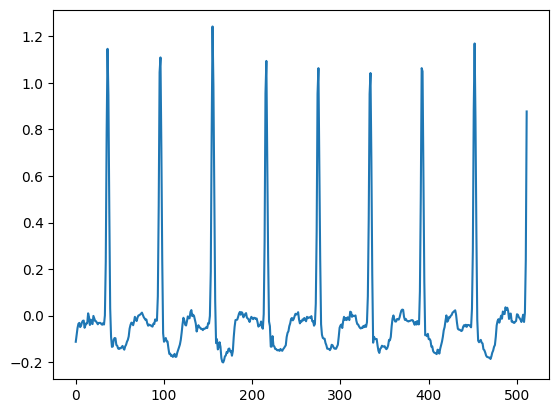

In [12]:
import matplotlib.pyplot as plt

x = batch['x'][0]
plt.plot(x[:, 0])

# augmentations

# models.py

In [1]:
import sys
sys.path.append("../src")


from models import SinusoidalPosEmb




In [3]:
import torch

pos_emb = SinusoidalPosEmb(dim=16)

x = torch.randn(1, 1000)
print(pos_emb(x).shape)

x = torch.randn(1, 1000, 12)
y = pos_emb(x) # (B, T, C) -> (B, T, C, 16)
print(y.shape)
# convert to (B, T, 16*C)
y = y.flatten(-2)
print(y.shape)

# 16*12 -> 192


torch.Size([1, 1000, 16])
torch.Size([1, 1000, 12, 16])
torch.Size([1, 1000, 192])


In [4]:
import sys
sys.path.append("../src")
from models import Extractor
import torch

extractor = Extractor(dim_base=128, dim=384)

x = torch.randn(2, 1000, 12)
y = extractor(x, Lmax=128)
print(y.shape)


627 755
torch.Size([2, 128, 384])


In [2]:
import sys
sys.path.append("../src")
from models import DeepHeartModel
import torch

model = DeepHeartModel()

x = torch.randn(2, 512, 12)
y = model(x)
print(y.shape)


torch.Size([2, 5])


In [3]:
%timeit y = model(x)

129 ms ± 5.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# augmentation

[INFO] Loading data...


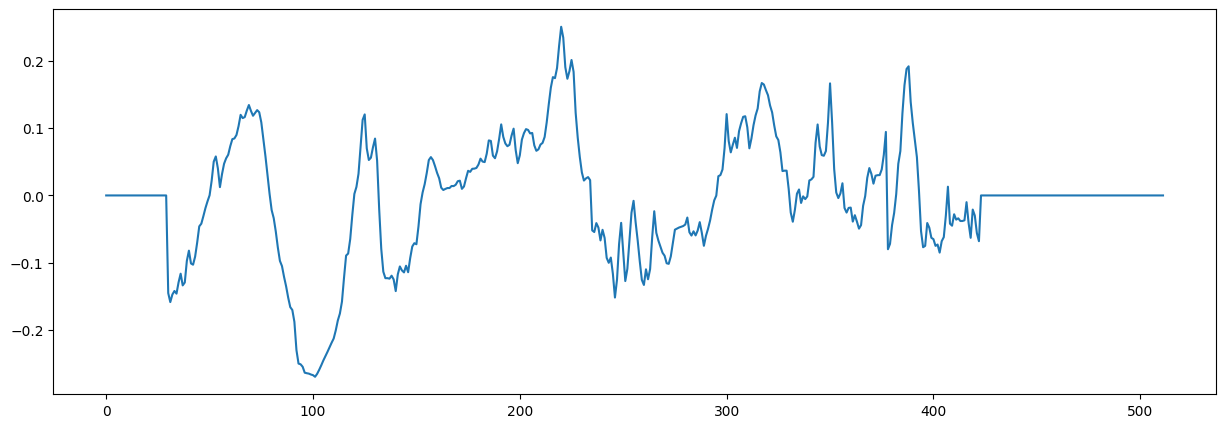

In [12]:
import sys
sys.path.append("../src")

from dataloaders import ECGDataset

ds_train = ECGDataset(
        "../data/data_dumps/sr100/",
        mode="train",
        L=512,
        test_folds=[9],
    )


import matplotlib.pyplot as plt
import numpy as np

# get random sample from training set
x = ds_train[np.random.randint(0, 19000)][0]['x'].numpy()


# plot on subfigures
plt.figure(figsize=(15, 5))
plt.plot(x[:, 0], label='original')


In [2]:
ds_train.X.shape

(19618, 1000, 12)

In [3]:
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse, AddNoise, Convolve, Dropout

tsuag_augmenter = (
    TimeWarp(prob=0.3)
    # # + Crop(size=(0.2, 0.4), prob=0.3)
    + Quantize(n_levels=5, per_channel=True, prob=0.3)
    + Drift(max_drift=(0.05, 0.25), prob=0.3)
    + Reverse(prob=0.3) 
    # + AddNoise(scale=0.02, prob=0.3)
    + Dropout(p=0.3, prob=0.3)
    + Convolve(size=12, prob=0.3)
    
)

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# get random sample from training set
x = ds_train[np.random.randint(0, 19000)][0]['x'].numpy()


# plot on subfigures
plt.figure(figsize=(15, 5))
x_augmented = tsuag_augmenter.augment(x)
plt.plot(x[:, 0], label='original')
# plt.plot(x_augmented[:, 0], label='augmented')

plt.legend()

ValueError: At least one stride in the given numpy array is negative, and tensors with negative strides are not currently supported. (You can probably work around this by making a copy of your array  with array.copy().) 

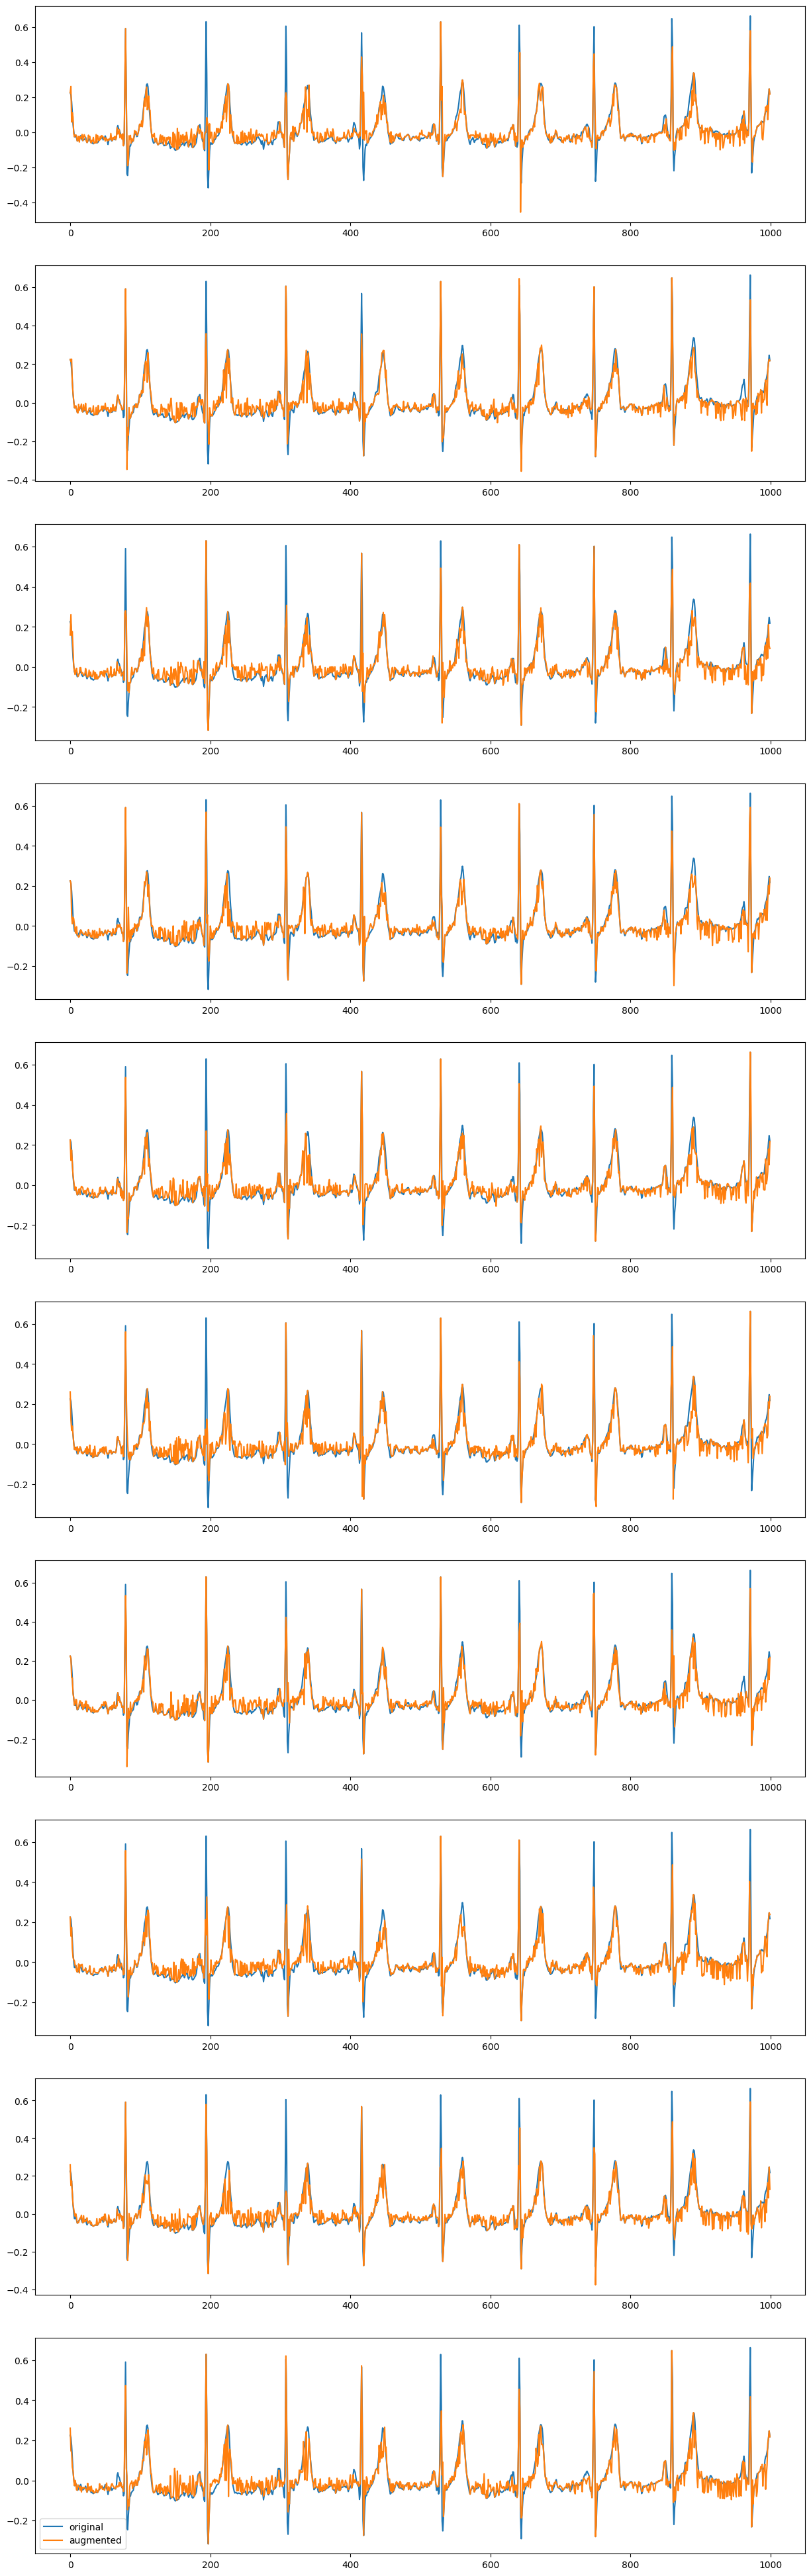

In [5]:
num_plots = 10
fig, axes = plt.subplots(nrows=num_plots, figsize=(15, 5*num_plots))



for i in range(num_plots):
    x_augmented = tsuag_augmenter.augment(x)
    axes[i].plot(x[:, 0], label='original')
    axes[i].plot(x_augmented[:, 0], label='augmented')



plt.legend()

In [69]:
import numpy as np
cutout_size_range = [0, 0.2]
np.random.uniform(low=cutout_size_range[0], high=cutout_size_range[1])

0.17600520199395245

In [1]:
import torch

weights = "/home/viktor/Documents/idoven/idoven-challenge/experiments/baseline-plus-augms/models/model_31.pth"
d = torch.load(weights)

In [2]:
d['proj_out.bias']

tensor([-0.0585, -0.0125, -0.0188, -0.0405, -0.0283, -0.0011], device='cuda:0')

In [4]:
import torch

weights = "/home/viktor/Documents/idoven/idoven-challenge/experiments/baseline-plus-augms/models/model_16.pth"
d = torch.load(weights)
d['proj_out.bias']

tensor([-0.0493, -0.0104, -0.0156, -0.0341, -0.0259, -0.0014], device='cuda:0')

In [5]:
import torch

weights = "/home/viktor/Documents/idoven/idoven-challenge/experiments/baseline-plus-augms/models/model_0.pth"
d = torch.load(weights)
d['proj_out.bias']

tensor([-0.0071, -0.0049, -0.0019, -0.0061, -0.0057, -0.0024], device='cuda:0')

In [3]:
for k in d.keys():
    if 'module.' in k:
        print(k)

In [2]:
import sys
sys.path.append("../src")

from dataloaders import ECGDataset


ds_train = ECGDataset(
        "../data/data_dumps/sr100/",
        mode="val",
        L=512,
        test_folds=[1,9,10],
        train_on_ffts=True,
        nfft_components=192
    )

[INFO] Loading data...


In [33]:
import numpy as np
y = ds_train[np.random.randint(0,100)][1]['y'].cpu().numpy()

y, np.unique(y)

(array([0., 1., 0., 0., 0., 0.], dtype=float32),
 array([0., 1.], dtype=float32))

In [23]:
import sys
sys.path.append("../src")

from dataloaders import ECGDataset

ds_train = ECGDataset(
        '../data/physionet.org/files/ptb-xl/1.0.2/',
        mode="train",
        L=384,
        test_folds=[1,9,10],
        train_on_ffts=False,
        augment=True
    )

[INFO] Loading data...
[INFO] Obtaining diagnostic_superclass for train mode ...
X.shape: (21396, 1000, 12), y.shape: (21396, 5)
X.min: -20.032, X.max: 17.212


In [24]:
import torch
dataloader = torch.utils.data.DataLoader(
            ds_train,
            batch_size=32,
            num_workers=4,
            persistent_workers=True,
        )

# time how fast is the dataloader
%time for batch in dataloader: pass

CPU times: user 132 ms, sys: 104 ms, total: 235 ms
Wall time: 7.17 s


In [26]:
from dataloaders import DeviceDataLoader


dataloader_2 = DeviceDataLoader(torch.utils.data.DataLoader(
            ds_train,
            batch_size=32,
            num_workers=4,
            persistent_workers=True,
        ))

# time how fast is the dataloader
%time for batch in dataloader_2: pass

CPU times: user 206 ms, sys: 198 ms, total: 404 ms
Wall time: 7.32 s


In [ ]:
from models import DeepHeartModel
MODEL_KWARGS = {
    "dim": 192,
    "dim_base": 128,
    "depth": 12,
    "head_size": 4,
    "drop_path": 0.2
  }
model = DeepHeartModel(**MODEL_KWARGS).cuda()


In [48]:
%time for batch in dataloader_2: input_data = {'x': batch[0]['x']}; model(input_data)

CPU times: user 26.1 s, sys: 68.6 ms, total: 26.2 s
Wall time: 26.3 s


In [47]:
input_data = {'x': batch[0]['x']}
%timeit model(input_data)

39.1 ms ± 24.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [37]:
for batch in dataloader_2:
    print(batch[0]['x'].shape)
    break

torch.Size([32, 384, 12])


In [35]:
batch[0]['x'].shape

torch.Size([32, 384, 12])

In [14]:
%timeit ds_train[0][0]['x']

387 µs ± 1.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [2]:
import numpy as np
x = ds_train.X[0]

x_new = []
num_channels = x.shape[1]
for channel in range(num_channels):
    x_channel = x[:, channel]


    # remove k=0 component
    x_channel = x_channel - np.mean(x_channel) 
    x_fft = np.fft.fftn(x_channel)
    # keep only the first nfft_components
    x_fft_keep = x_fft[:192]
    # normalize
    mean = np.mean(x_fft_keep)
    std = np.std(x_fft_keep)
    x_fft_keep = (x_fft_keep - mean) / std
    x_new.append(x_fft_keep)

x_new = np.array(x_new).T

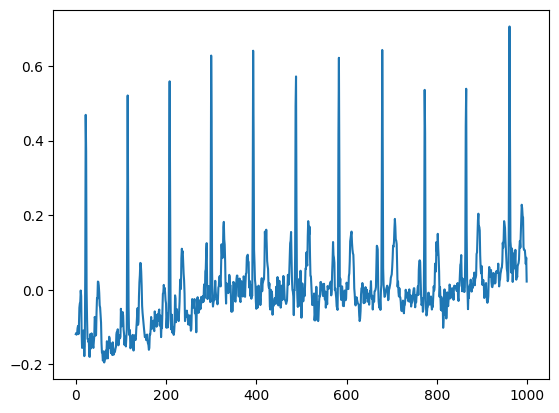

In [3]:
import matplotlib.pyplot as plt

plt.plot(x[:, 0])

In [6]:
x[:, 0][:10]

array([-0.119, -0.116, -0.12 , -0.117, -0.103, -0.097, -0.119, -0.096,
       -0.048, -0.037])

In [4]:
x[:, 0].shape

(1000,)

In [9]:
x_2 = ds_train.X[0, :, 0]
y_2=np.fft.fftn(x_2 - np.mean(x_2))
x_2[:10], y_2[:10]

(array([-0.119, -0.116, -0.12 , -0.117, -0.103, -0.097, -0.119, -0.096,
        -0.048, -0.037]),
 array([ 1.55431223e-15 +0.j        , -1.20830991e+01+15.54415881j,
         3.98648859e+00+21.07500726j,  8.56451353e+00+13.72209337j,
         2.34557817e+00+10.27909629j,  9.15528965e-01 +8.7713629j ,
         4.55243921e+00 +4.27193817j,  3.65136174e+00 +4.2973012j ,
         1.86022053e+00 +6.37860692j,  2.00302321e+00 +2.39323289j]))